In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.svm import SVC

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Lendo a base de dados

In [2]:
df = pd.read_csv('winequality-red.csv')
df.shape

(1599, 12)

In [3]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

### Pré-processamento

In [4]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Não temos valores nulos

In [5]:
df.duplicated().sum()

240

Temos 240 valores duplicados, vamos jogar eles fora

In [6]:
df.drop_duplicates(inplace=True)

### EDA Simples

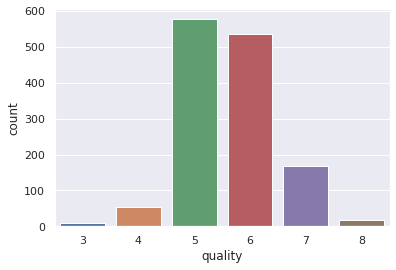

In [7]:
sns.countplot(df['quality'])

Podemos ver que nossas classes são um tanto quanto desbalanceadas

Vamos fazer um pouco de análise bivariada

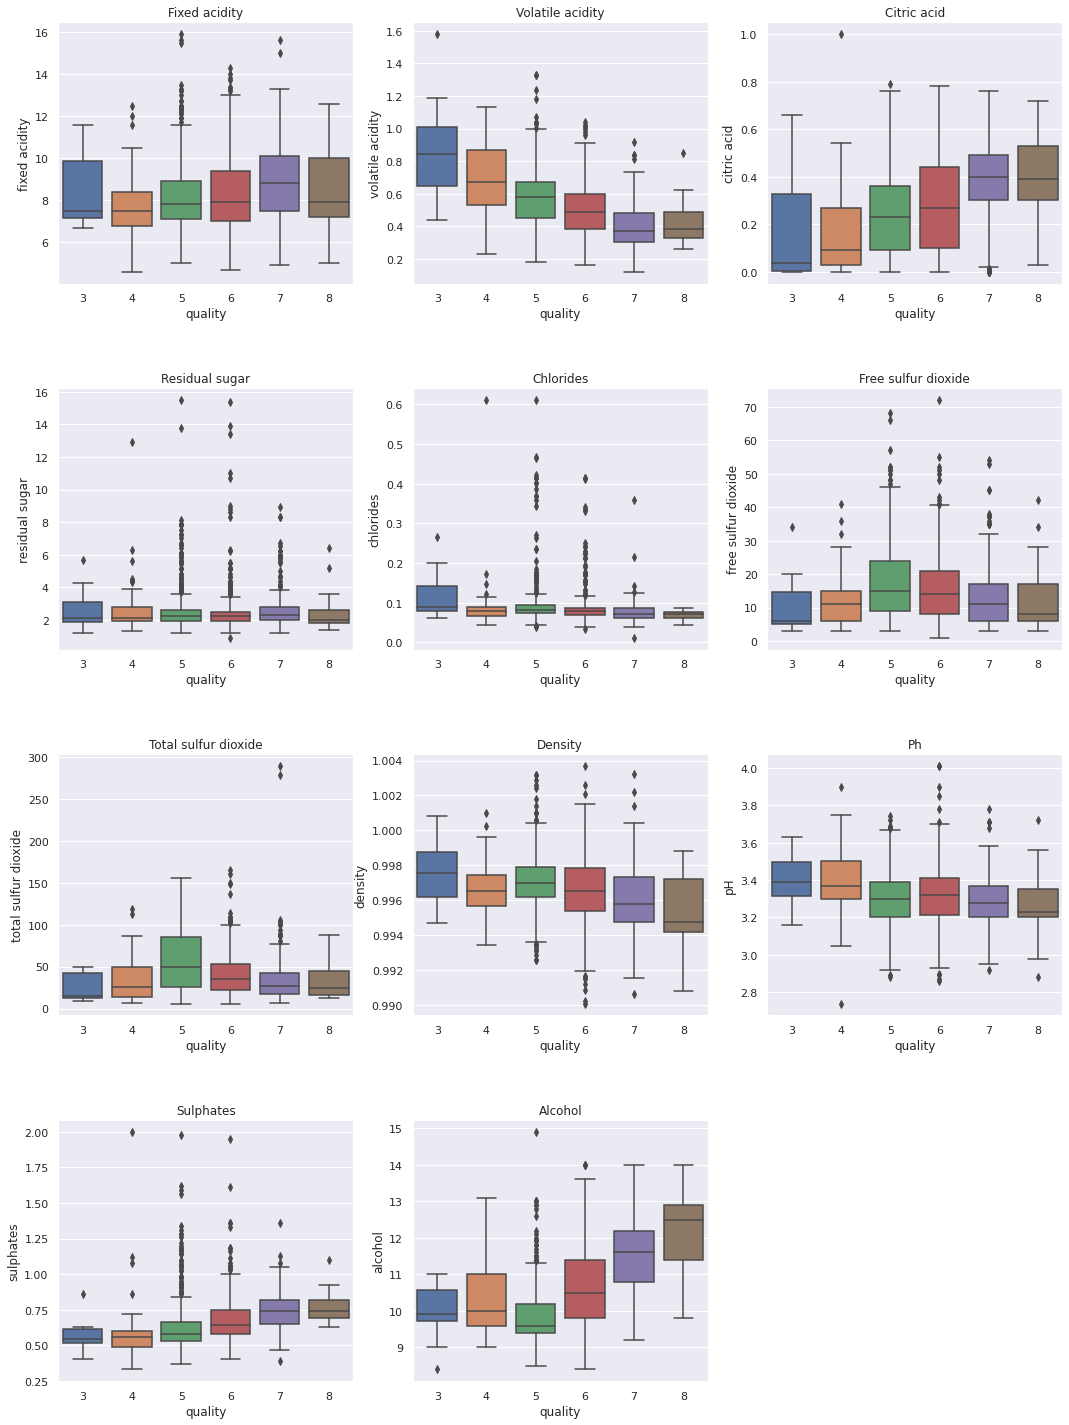

In [8]:
target = 'quality'
features = list(df.columns)
features.remove(target)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 25))
plt.subplots_adjust(hspace=0.4)

for i, feat in enumerate(features):
    sns.boxplot(y=feat, x=target, data=df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(feat.capitalize())
    
axes[3,2].axis('off');

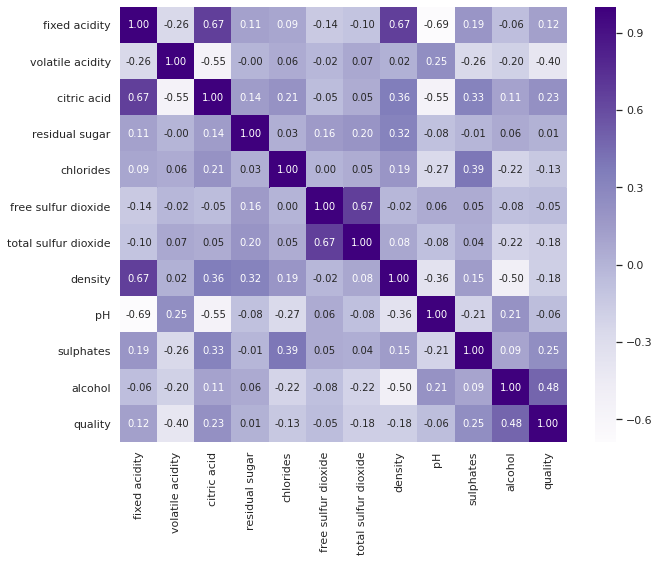

In [9]:
corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Purples')

### Classificação

In [10]:
# Vamos guardar o resultado de todos os métodos aqui, para compararmos
all_results = {}

In [11]:
target = 'quality'
features = list(df.columns)
features.remove(target)

In [12]:
X, y = df[features].values, df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1087, 11)
(272, 11)
(1087,)
(272,)


**Normalizando os dados**

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
print(X_train.mean(axis=0))
print(X_train.std(axis=0))

[ 6.35186476e-16  1.15771647e-16 -1.19091081e-16 -4.96524299e-16
  9.34458991e-15 -3.11260779e-17 -1.96101951e-17  1.71404238e-13
 -1.79682498e-14 -4.97664876e-15  2.37523381e-14]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
print(X_test.mean(axis=0))
print(X_test.std(axis=0))

[ 0.01268692 -0.10469834  0.1033508   0.1244314  -0.01027964  0.09358931
  0.13398501  0.03686862 -0.02629205  0.17703609  0.04161751]
[1.07676369 0.98920226 0.98368666 1.34224063 0.98920389 1.10335875
 1.16436858 1.12322893 1.08048856 1.22364694 1.04161233]


#### KNN

In [16]:
k_values = np.arange(1, 30)
results = {}

best_k = 1

kfold = KFold(n_splits=5)

for k in k_values:
    scores = []
    for train_idx, val_idx in kfold.split(X_train, y_train):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train[train_idx], y_train[train_idx])
        y_pred = model.predict(X_train[val_idx])
        
        acc = accuracy_score(y_train[val_idx], y_pred)
        scores.append(acc)
        
    results[k] = np.mean(scores)
    if results[k] > results[best_k]:
        best_k = k

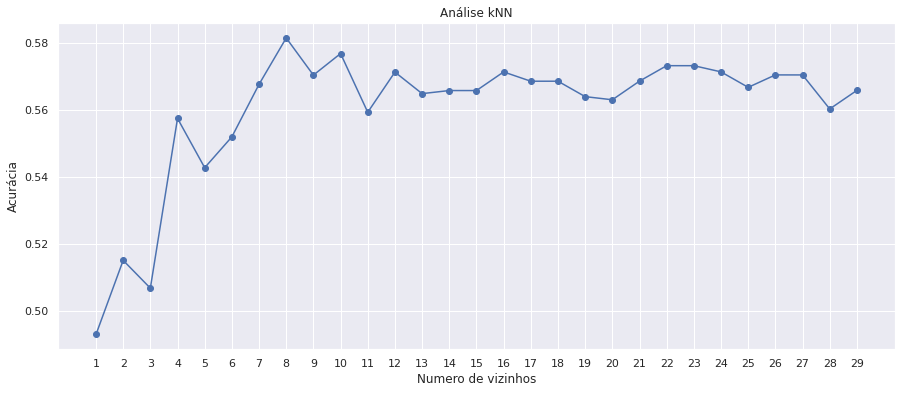

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(list(results.keys()), list(results.values()), '-o')
plt.xlabel('Numero de vizinhos')
plt.ylabel('Acurácia')
plt.xticks(k_values)
plt.title('Análise kNN');

In [18]:
print('Melhor k: ', best_k)

Melhor k:  8


In [19]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
all_results['kNN'] = acc
print(f'Acurácia para melhor k: {acc:.4f}')

Acurácia para melhor k: 0.5588


#### Árvore de decisão

In [20]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
all_results['Árvore de decisão'] = acc
print(f'Acurácia: {acc:.4f}')

Acurácia: 0.4853


#### Naive Bayes

In [21]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
all_results['Naive Bayes'] = acc
print(f'Acurácia: {acc:.4f}')

Acurácia: 0.4816


#### SVM

In [22]:
c_values = np.arange(1, 5, 0.1)
results = {}

best_c = 1

kfold = KFold(n_splits=5)

for c in c_values:
    scores = []
    for train_idx, val_idx in kfold.split(X_train, y_train):
        model = SVC(C=c)
        model.fit(X_train[train_idx], y_train[train_idx])
        y_pred = model.predict(X_train[val_idx])
        
        acc = accuracy_score(y_train[val_idx], y_pred)
        scores.append(acc)
        
    results[c] = np.mean(scores)
    if results[c] > results[best_c]:
        best_c = c

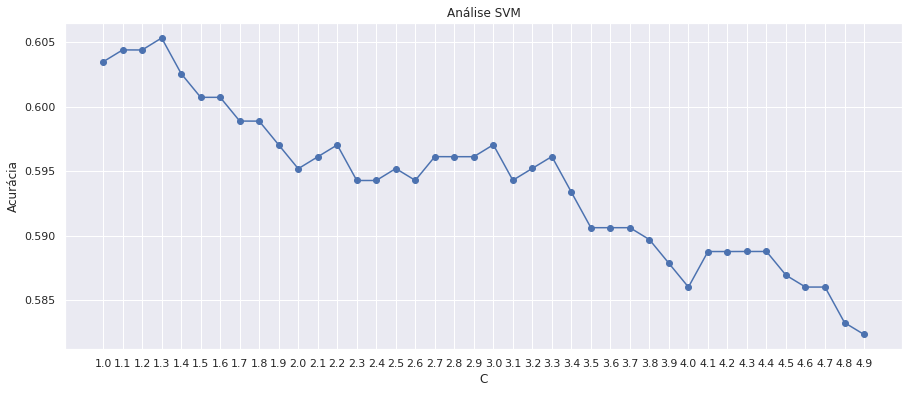

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(list(results.keys()), list(results.values()), '-o')
plt.xlabel('C')
plt.ylabel('Acurácia')
plt.xticks(c_values)
plt.title('Análise SVM');

In [24]:
print('Melhor c: ', best_c)

Melhor c:  1.3000000000000003


In [25]:
model = SVC(C=best_c)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
all_results['SVM'] = acc
print(f'Acurácia para melhor c: {acc:.4f}')

Acurácia para melhor c: 0.5846


#### Random Forest

In [26]:
n_estimators_values = np.arange(1, 250, 10)
results = {}

best_n_estimators = 1

kfold = KFold(n_splits=5)

for n_estimators in n_estimators_values:
    scores = []
    for train_idx, val_idx in kfold.split(X_train, y_train):
        model = RandomForestClassifier(n_estimators=n_estimators)
        model.fit(X_train[train_idx], y_train[train_idx])
        y_pred = model.predict(X_train[val_idx])
        
        acc = accuracy_score(y_train[val_idx], y_pred)
        scores.append(acc)
        
    results[n_estimators] = np.mean(scores)
    if results[n_estimators] > results[best_n_estimators]:
        best_n_estimators = n_estimators

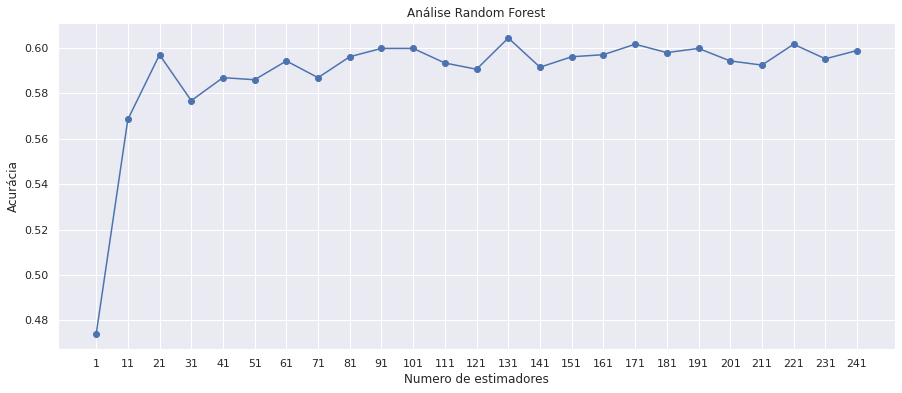

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(list(results.keys()), list(results.values()), '-o')
plt.xlabel('Numero de estimadores')
plt.ylabel('Acurácia')
plt.xticks(n_estimators_values)
plt.title('Análise Random Forest');

In [28]:
print('Melhor numero de estimadores: ', best_n_estimators)

Melhor numero de estimadores:  131


In [29]:
model = RandomForestClassifier(n_estimators=best_n_estimators)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
all_results['Random Forest'] = acc
print(f'Acurácia para melhor numero de estimadores: {acc:.4f}')

Acurácia para melhor numero de estimadores: 0.5478


Vamos observar o feature importance produzido

In [30]:
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

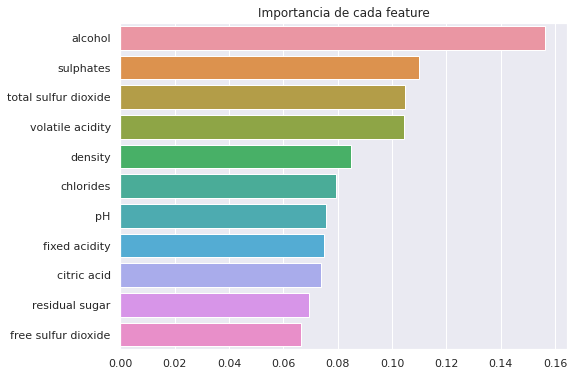

In [31]:
importances = model.feature_importances_
model_features = np.array(features)

ordered_idx = np.argsort(importances)
ordered_idx = ordered_idx[::-1] #invertendo para ficar decrescente


plt.figure(figsize=(8, 6))
sns.barplot(x=importances[ordered_idx], y=model_features[ordered_idx])
plt.title('Importancia de cada feature');

#### Comparação dos diferentes algoritmos

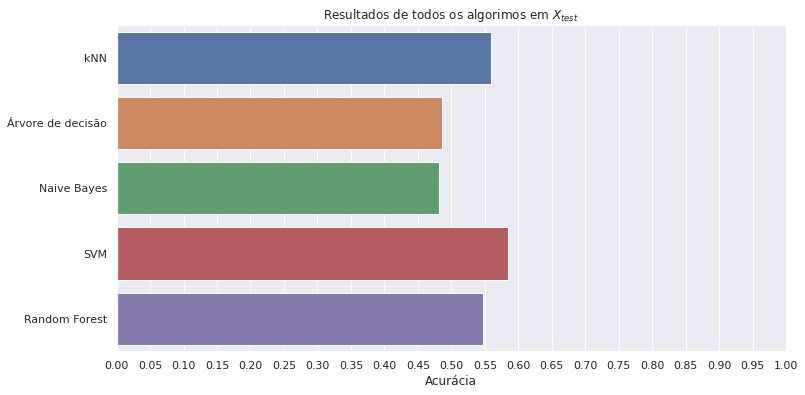

In [32]:
algs = list(all_results.keys())
accs = list(all_results.values())

plt.figure(figsize=(12, 6))
sns.barplot(accs, algs)
plt.title(r'Resultados de todos os algorimos em $X_{test}$')
plt.xlabel('Acurácia')
plt.xticks(np.arange(0, 1.05, 0.05));

### Regressão

In [33]:
all_results = {}
all_results['r2'] = {}
all_results['mse'] = {}

In [34]:
target = 'alcohol'
features = list(df.columns)
features.remove(target)

X, y = df[features].values, df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1087, 11)
(272, 11)
(1087,)
(272,)


In [35]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
print(X_train.mean(axis=0))
print(X_train.std(axis=0))

[ 6.35186476e-16  1.15771647e-16 -1.19091081e-16 -4.96524299e-16
  9.34458991e-15 -3.11260779e-17 -1.96101951e-17  1.71404238e-13
 -1.79682498e-14 -4.97664876e-15  2.77811097e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [37]:
print(X_test.mean(axis=0))
print(X_test.std(axis=0))

[ 0.01268692 -0.10469834  0.1033508   0.1244314  -0.01027964  0.09358931
  0.13398501  0.03686862 -0.02629205  0.17703609  0.03065676]
[1.07676369 0.98920226 0.98368666 1.34224063 0.98920389 1.10335875
 1.16436858 1.12322893 1.08048856 1.22364694 1.01381494]


#### Regressão linear

In [38]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

all_results['r2']['Random Forest'] = r2
all_results['mse']['Random Forest'] = mse

print(f'r2: {r2:.4f}')
print(f'MSE: {mse:.4f}')

r2: 0.6454
MSE: 0.4425


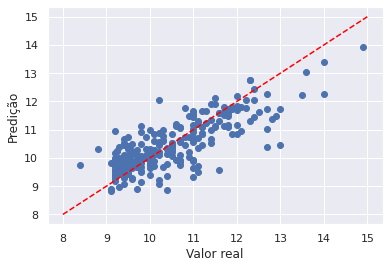

In [39]:
plt.scatter(y_test, y_pred)
plt.plot(np.arange(8, 16), np.arange(8, 16), '--', color='red')

plt.xlabel('Valor real')
plt.ylabel('Predição');

In [40]:
mse_ridge = []
alpha_ridge = []

for alpha in np.arange(0,10,0.5):
    ridge = Ridge(alpha = alpha, normalize = True)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_ridge.append(mse)
    alpha_ridge.append(alpha)

In [41]:
mse_lasso = []
alpha_lasso = []
for alpha in np.arange(0.01,2,0.1):
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    RSME = mean_squared_error(y_test, y_pred)
    mse_lasso.append(RSME)
    alpha_lasso.append(alpha)

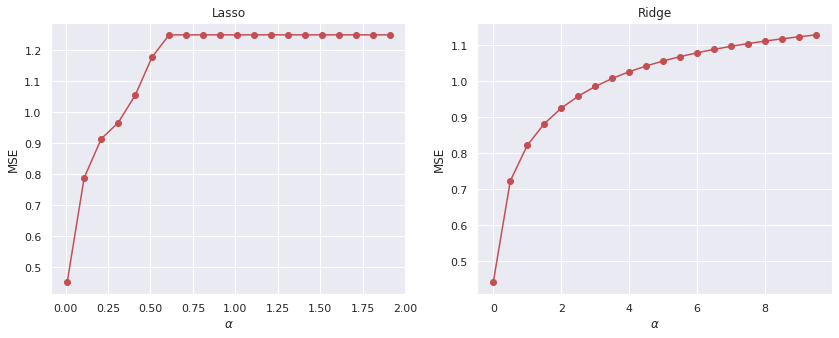

In [42]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(alpha_lasso, mse_lasso, '-ro')
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE")
plt.title('Lasso')

plt.subplot(122)
plt.plot(alpha_ridge, mse_ridge, '-ro')
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE")
plt.title('Ridge');

Podemos ver que para ambos os casos o melhor resultado ocorreu quando $\alpha = 0$, ou seja, quando nosso modelo é um regressão linear.